In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa.display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import torch.nn.functional as F

In [3]:
emotions_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5
}

In [4]:
x_train_text = pd.read_csv('../data/text_train.csv')
x_test_text = pd.read_csv('../data/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('../data/audio_train_v0.csv')
x_test_audio = pd.read_csv('../data/audio_test_v0.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(7837, 3) (7837,) (7837, 278) (7837,)


In [5]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))
print(cl_weight)

{2: 0.29539364552762537, 5: 0.17481179022585172, 1: 0.16855939772872272, 3: 0.12696184764578283, 4: 0.11981625622049254, 0: 0.11445706265152482}


In [6]:
# Check if both DataFrames have the 'transcription' column
print("x_train_text columns:", x_train_text.columns)
print("x_test_text columns:", x_test_text.columns)

x_train_text columns: Index(['wav_file', 'label', 'transcription'], dtype='object')
x_test_text columns: Index(['wav_file', 'label', 'transcription'], dtype='object')


In [7]:
# Concatenate the 'transcription' columns directly
transcription_train = x_train_text['transcription']
transcription_test = x_test_text['transcription']
combined_transcription = pd.concat([transcription_train, transcription_test])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Apply TfidfVectorizer
features_text = tfidf.fit_transform(combined_transcription).toarray()

# Split back into train and test sets
x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(9797, 2464) (7837, 2464) (1960, 2464)


In [8]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

(7837, 2740) (1960, 2740)


In [9]:
# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(combined_x_train,1)
X_test = np.expand_dims(combined_x_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'Shape of feature array for input tensor: {X_train.shape} train, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_test.shape} test')

Shape of feature array for input tensor: (7837, 1, 2740) train, (1960, 1, 2740) test
Shape of emotion labels: (7837,) train, (1960,) test


In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet1D, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        #layers.append(nn.Dropout(dropout))  # Add dropout layer after the block
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.avg_pool1d(out, out.size(2))
        out = out.view(out.size(0), -1)
        out_logits = self.linear(out)
        out_softmax = F.softmax(out_logits, dim=1)
        return out_logits, out_softmax

In [11]:
model = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=len(emotions_dict))

print(model)

ResNet1D(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(64, 64, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [12]:
# define loss function: CrossEntropyLoss()
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [13]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X,Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [14]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()

            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [15]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [16]:
train_size = X_train.shape[0]
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = ResNet1D(BasicBlock, [2, 2, 2, 2, 2], num_classes=len(emotions_dict)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

optimizer = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-4, momentum=0.4)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []
train_accuracy = []
valid_accuracy = []


# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)
        X_train = X_train[train_indices,:]
        Y_train = Y_train[train_indices]

        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            batch_end = min(batch_start + minibatch, train_size)
            actual_batch_size = batch_end-batch_start

            # create tensors from minibatch
            X = X_train[batch_start:batch_end,:]
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')

        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)

        # calculate validation metrics to keep track of progress
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        train_accuracy.append(epoch_acc)
        valid_accuracy.append(valid_acc)

        # Save checkpoint of the model
        # If valid loss is lowest, save it as the best model
        if valid_loss == min(valid_losses):
            checkpoint_filename = '../savedModel/CNN1D_v2_best_loss.pkl'
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        if valid_acc == max(valid_accuracy):
            checkpoint_filename = '../savedModel/CNN1D_v2_best_acc.pkl'
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        checkpoint_filename = '../data/model_checkpoints/CNN1D_v2-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

cpu selected
Number of trainable params:  15398854


c:\Users\Zara Mudassar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# choose number of epochs higher than reasonable so we can manually stop training
num_epochs = 50

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_test, y_test)

Epoch 0: iteration 243/244
Epoch 0 --- loss:1.594, Epoch accuracy:34.22%, Validation loss:1.440, Validation accuracy:45.41%
Epoch 1: iteration 243/244
Epoch 1 --- loss:1.321, Epoch accuracy:49.67%, Validation loss:1.177, Validation accuracy:55.15%
Epoch 2: iteration 243/244
Epoch 2 --- loss:1.102, Epoch accuracy:57.57%, Validation loss:1.017, Validation accuracy:60.05%
Epoch 3: iteration 243/244
Epoch 3 --- loss:0.946, Epoch accuracy:63.24%, Validation loss:0.905, Validation accuracy:64.08%
Epoch 4: iteration 243/244
Epoch 4 --- loss:0.843, Epoch accuracy:67.12%, Validation loss:0.857, Validation accuracy:65.05%
Epoch 5: iteration 243/244
Epoch 5 --- loss:0.768, Epoch accuracy:70.69%, Validation loss:0.829, Validation accuracy:66.02%
Epoch 6: iteration 243/244
Epoch 6 --- loss:0.700, Epoch accuracy:73.61%, Validation loss:0.835, Validation accuracy:65.87%
Epoch 7: iteration 243/244
Epoch 7 --- loss:0.632, Epoch accuracy:76.53%, Validation loss:0.836, Validation accuracy:65.05%
Epoch 8:

In [19]:
# choose number of epochs higher than reasonable so we can manually stop training
num_epochs = 20

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_test, y_test)

Epoch 0: iteration 243/244
Epoch 0 --- loss:0.002, Epoch accuracy:99.63%, Validation loss:1.411, Validation accuracy:66.02%
Epoch 1: iteration 243/244
Epoch 1 --- loss:0.002, Epoch accuracy:99.63%, Validation loss:1.395, Validation accuracy:65.71%
Epoch 2: iteration 243/244
Epoch 2 --- loss:0.001, Epoch accuracy:99.63%, Validation loss:1.400, Validation accuracy:66.17%
Epoch 3: iteration 243/244
Epoch 3 --- loss:0.002, Epoch accuracy:99.63%, Validation loss:1.387, Validation accuracy:65.92%
Epoch 4: iteration 243/244
Epoch 4 --- loss:0.001, Epoch accuracy:99.63%, Validation loss:1.433, Validation accuracy:66.12%
Epoch 5: iteration 243/244
Epoch 5 --- loss:0.001, Epoch accuracy:99.63%, Validation loss:1.393, Validation accuracy:66.22%
Epoch 6: iteration 243/244
Epoch 6 --- loss:0.001, Epoch accuracy:99.63%, Validation loss:1.398, Validation accuracy:66.12%
Epoch 7: iteration 243/244
Epoch 7 --- loss:0.001, Epoch accuracy:99.63%, Validation loss:1.409, Validation accuracy:66.07%
Epoch 8:

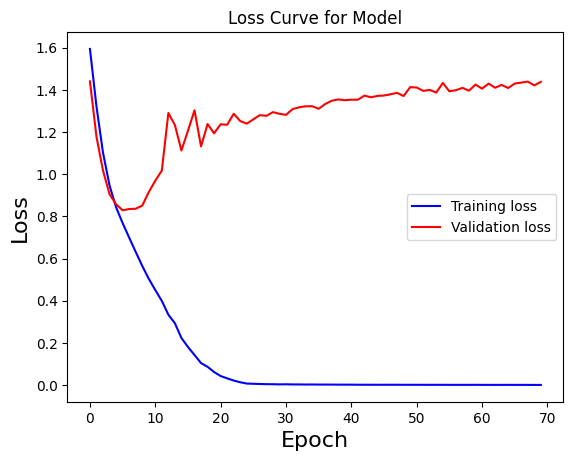

In [20]:
plt.title('Loss Curve for Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

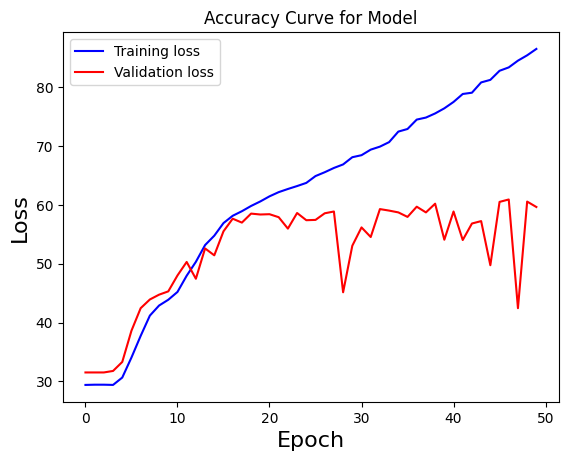

In [53]:
plt.title('Accuracy Curve for Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_accuracy[:],'b')
plt.plot(valid_accuracy[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()